### detectron2_fasterrcnn.ipynb
### Authors: Indu Panigrahi and Raymond Liu


### Set-up

In [ ]:
# You do not need to run this cell if you are not using Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# !pip install -U git+https://github.com/facebookresearch/fvcore.git
!pip install -U git+https://github.com/ind1010/fvcore
!pip install -U iopath==0.1.4
!pip install portalocker
!pip install omegaconf

!pip install --upgrade albumentations

You will need to clone our repository and change the following directory path accordingly.

In [ ]:
%cd /content/drive/MyDrive/429\ Final\ Project/detectron2/

/content/drive/MyDrive/429 Final Project/detectron2


In [ ]:
!python setup.py build develop

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# # import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# # import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# # for evaluation
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
import argparse
import logging
import os
import sys
import weakref
from collections import OrderedDict
from typing import Optional
import torch
from fvcore.nn.precise_bn import get_bn_modules
from omegaconf import OmegaConf
from torch.nn.parallel import DistributedDataParallel

import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import CfgNode, LazyConfig
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
    DatasetMapper,
)
from detectron2.evaluation import (
    DatasetEvaluator,
    inference_on_dataset,
    print_csv_format,
    verify_results,
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils import comm
from detectron2.utils.collect_env import collect_env_info
from detectron2.utils.env import seed_all_rng
from detectron2.utils.events import CommonMetricPrinter, JSONWriter, TensorboardXWriter
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import setup_logger

from detectron2.engine import hooks
from detectron2.engine.train_loop import AMPTrainer, SimpleTrainer, TrainerBase

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.LossEvalHook import LossEvalHook
from detectron2.data import DatasetCatalog

class PedestrianTrainer(DefaultTrainer):
  @classmethod
  def build_train_loader(cls, cfg):
    """
    Returns:
        iterable

    It now calls :func:`detectron2.data.build_detection_train_loader`.
    Overwrite it if you'd like a different data loader.
    """
    ############################################################################
    # refer to detectron2.data.transforms documentation for information about augmentations
    # custom_augmentations = [T.RandomCrop("relative_range",(0.33, 0.5)),\
    #                         T.RandomFlip(),T.RandomFlip(horizontal=False,vertical=True),\
    #                         T.RandomRotation([30.0,90.0],expand=False),\
    #                         T.ResizeShortestEdge(short_edge_length=[800, 1000], max_size=1333, sample_style='range')]
                            # The Colab GPU couldn't handle the image sizes so had to use ResizeShortestEdge transform
    custom_augmentations = []
    return build_detection_train_loader(cfg, mapper=DatasetMapper(augmentations=custom_augmentations,
                                                                  is_train=True,image_format="BGR",use_instance_mask=True))

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    """
    Returns:
        DatasetEvaluator or None

    It was not implemented by default.
    """
    # adapted from train_net.py
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    return COCOEvaluator(dataset_name)

                         
  def build_hooks(self):
      hooks = super().build_hooks()
      hooks.insert(-1,LossEvalHook(
          cfg.TEST.EVAL_PERIOD,
          self.model,
          build_detection_test_loader(
              self.cfg,
              self.cfg.DATASETS.TEST[0],
              DatasetMapper(self.cfg,True)
          )
      ))
      return hooks

### Register datasets

In [ ]:
# register training, validation, and test datasets
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train", {}, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/train/train.json", "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/train/")
register_coco_instances("test", {}, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/test/test.json", "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/test/")
register_coco_instances("val", {}, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/val/val.json", "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/val/")

### Finetune a Faster R-CNN pretrained on the MS COCO 2017 dataset

In [ ]:
%xmode Verbose

Exception reporting mode: Verbose


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)
cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 1e-3 
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "/content/drive/MyDrive/429 Final Project/checkpoints_1.5_loss_for_none"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = PedestrianTrainer(cfg)
model = trainer.model

# train
trainer.resume_or_load(resume=True)
trainer.train()

Streaming output truncated to the last 5000 lines.
[12/13 08:03:31 d2.evaluation.evaluator]: Inference done 126/200. Dataloading: 0.0018 s/iter. Inference: 0.0853 s/iter. Eval: 0.0002 s/iter. Total: 0.0874 s/iter. ETA=0:00:06
[12/13 08:03:36 d2.evaluation.evaluator]: Inference done 183/200. Dataloading: 0.0018 s/iter. Inference: 0.0857 s/iter. Eval: 0.0002 s/iter. Total: 0.0877 s/iter. ETA=0:00:01
[12/13 08:03:37 d2.evaluation.evaluator]: Total inference time: 0:00:17.195891 (0.088184 s / iter per device, on 1 devices)
[12/13 08:03:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:16 (0.085734 s / iter per device, on 1 devices)
[12/13 08:03:37 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/13 08:03:37 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).

Code to check file of None image names

In [ ]:
none_files = open('train_none.txt','r')

In [ ]:
none_files = none_files.readlines()
none_files = [line.rstrip() for line in none_files]

Code to check file for current image name

In [ ]:
curr = open('currentimage.txt','r')

In [ ]:
currimage = curr.read().rstrip()

Code to visualize bounding boxes

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("validate",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "/content/drive/MyDrive/429 Final Project/checkpoints/"

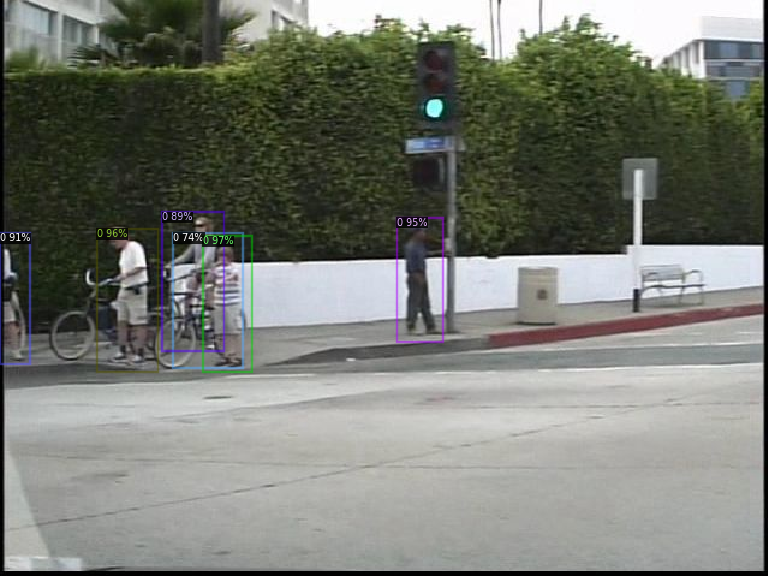

In [ ]:
# check bounding boxes, 0 means "person" category in Caltech Pedestrian Dataset
im = cv2.imread("/content/drive/.shortcut-targets-by-id/1eMGN3T21SwJrKCoG0JaNQgw-ioJUtKiz/429 Final Project/caltech_pedestrian_dataset/val/set07_V010_1076.jpg")
cv2_imshow(im)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml") # pretrained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0006999.pth") # our checkpoints
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

### Training Metrics

1.5 Loss for None Training Metrics

In [ ]:
f = open('/content/drive/.shortcut-targets-by-id/1eMGN3T21SwJrKCoG0JaNQgw-ioJUtKiz/429 Final Project/checkpoints_1.5_loss_for_none/metrics.json')

points = f.readlines()
losses = np.zeros(1)
val_losses = np.zeros(1)
for i,pt in enumerate(points):
  metric = json.loads(pt)
  if 'total_loss' in metric.keys():
    losses = np.append(losses, metric['total_loss'])
  if 'validation_loss' in metric.keys():
    val_losses = np.append(val_losses, metric['validation_loss'])
losses = losses[1:]
val_losses = val_losses[1:]
f.close()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(losses.shape[0]),losses)

In [ ]:
plt.plot(np.arange(val_losses.shape[0]),val_losses)

Double Loss for None Training Metrics

In [ ]:
f = open('/content/drive/.shortcut-targets-by-id/1eMGN3T21SwJrKCoG0JaNQgw-ioJUtKiz/429 Final Project/checkpoints_double_loss_for_none/metrics.json')

points = f.readlines()
losses = np.zeros(1)
val_losses = np.zeros(1)
for i,pt in enumerate(points):
  metric = json.loads(pt)
  if 'total_loss' in metric.keys():
    losses = np.append(losses, metric['total_loss'])
  if 'validation_loss' in metric.keys():
    val_losses = np.append(val_losses, metric['validation_loss'])
losses = losses[1:]
val_losses = val_losses[1:]
f.close()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(losses.shape[0]),losses)

In [ ]:
plt.plot(np.arange(val_losses.shape[0]),val_losses)

Original Model Training Metrics

In [ ]:
f = open('/content/drive/.shortcut-targets-by-id/1eMGN3T21SwJrKCoG0JaNQgw-ioJUtKiz/429 Final Project/checkpoints/metrics.json')

points = f.readlines()
losses = np.zeros(1)
val_losses = np.zeros(1)
for i,pt in enumerate(points):
  metric = json.loads(pt)
  if 'total_loss' in metric.keys():
    losses = np.append(losses, metric['total_loss'])
  if 'validation_loss' in metric.keys():
    val_losses = np.append(val_losses, metric['validation_loss'])
losses = losses[1:]
val_losses = val_losses[1:]
f.close()

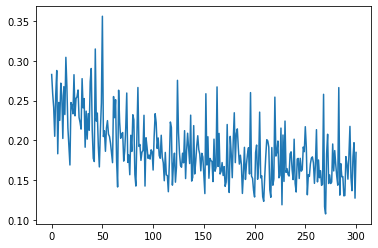

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(losses.shape[0]),losses)

In [ ]:
plt.plot(np.arange(val_losses.shape[0]),val_losses)

### Evaluation on Categories

In [ ]:
# register category datasets
from detectron2.data.datasets import register_coco_instances
register_coco_instances("masked", {}, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/masked/masked.json", "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/masked/")
register_coco_instances("crosswalks", {}, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/crosswalks/crosswalks.json", "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/crosswalks/")
register_coco_instances("sidewalks", {}, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/sidewalks/sidewalks.json", "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/sidewalks/")
register_coco_instances("none", {}, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none/none.json", "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none/")

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("validate",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "/content/drive/MyDrive/429 Final Project/checkpoints_1.5_loss_for_none/"

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0007999.pth")
predictor = DefaultPredictor(cfg)

Use customized pycocotools to incorporate Normalized Average Precision.

In [ ]:
!pip uninstall pycocotools

Found existing installation: pycocotools 2.0.3
Uninstalling pycocotools-2.0.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pycocotools-2.0.3-py3.7-linux-x86_64.egg
Proceed (y/n)? y
  Successfully uninstalled pycocotools-2.0.3


In [ ]:
%cd detectron2/cocoapi/PythonAPI/

/content/drive/My Drive/429 Final Project/detectron2/detectron2/cocoapi/PythonAPI


In [ ]:
!python setup.py build_ext install

In [ ]:
%cd ../../..

/content/drive/.shortcut-targets-by-id/1eMGN3T21SwJrKCoG0JaNQgw-ioJUtKiz/429 Final Project/detectron2


In [ ]:
!touch average_precisions.txt

In [ ]:
f = open("average_precisions.txt", "r")
print(f.readlines())
f.close()

[]


#### After manipulating training loss weights

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import glob
from detectron2.data.datasets import register_coco_instances

# loop and save APs
filenames = glob.glob('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/crosswalks/*.jpg')

for fl in filenames:
  name = (fl.split('.'))[0].split('/')[-1]
  json_dir = "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/crosswalks_annotations/"+name+".json"
  register_coco_instances(name, {}, json_dir, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/crosswalks/")
  evaluator = COCOEvaluator(name, output_dir="../output_crosswalks2")
  val_loader = build_detection_test_loader(cfg, name)
  print(inference_on_dataset(predictor.model, val_loader, evaluator))

[12/13 09:05:33 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/crosswalks_annotations/set08_V009_290.json
[12/13 09:05:33 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 1            |
|            |              |
[12/13 09:05:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/13 09:05:33 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[12/13 09:05:33 d2.data.common]: Serialized dataset takes 0.00 MiB
[12/13 09:05:33 d2.evaluation.evaluator]: Start inference on 1 batches
[12/13 09:05:34 d2.evaluation.evaluator]: Inference done 1/1. Dataloading: 0.0000 s/iter. Inference: 0.5443 s/iter. Eval: 0.0005 s/iter. Total: 0.5448 s/iter. ETA=0:00:00
[12/13 09:05:34 d2.e

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import glob
from detectron2.data.datasets import register_coco_instances

# loop and save APs
filenames = glob.glob('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/sidewalks/*.jpg')
# j = 0
for fl in filenames:
  name = (fl.split('.'))[0].split('/')[-1]
  json_dir = "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/sidewalks_annotations/"+name+".json"
  register_coco_instances(name, {}, json_dir, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/sidewalks/")
  evaluator = COCOEvaluator(name, output_dir="../output_sidewalks2")
  val_loader = build_detection_test_loader(cfg, name)
  print(inference_on_dataset(predictor.model, val_loader, evaluator))
  # j+=1

Streaming output truncated to the last 5000 lines.
{'AP': 50.0, 'AP50': 100.0, 'AP75': 0.0, 'APs': 50.0, 'APm': nan, 'APl': nan}
{'AP': 60.0, 'AP50': 100.0, 'AP75': 100.0, 'APs': 60.0, 'APm': nan, 'APl': nan}
{'AP': 10.099009900990099, 'AP50': 33.663366336633665, 'AP75': 0.0, 'APs': 10.099009900990099, 'APm': nan, 'APl': nan}
{'AP': 44.81105632477464, 'AP50': 83.00742130611675, 'AP75': 33.462726413301716, 'APs': 55.04309821438931, 'APm': 25.247524752475247, 'APl': nan}
{'AP': 26.718354529893613, 'AP50': 50.360755946341015, 'AP75': 16.435130378393005, 'APs': 26.718354529893613, 'APm': nan, 'APl': nan}
{'AP': 39.82073412967712, 'AP50': 66.33663366336634, 'AP75': 33.262086489969775, 'APs': 0.0, 'APm': 60.01843376582442, 'APl': nan}
{'AP': 28.265597508726348, 'AP50': 66.14072727574953, 'AP75': 33.07546262834457, 'APs': 35.00603154477293, 'APm': 27.920792079207924, 'APl': nan}
{'AP': 60.0, 'AP50': 100.0, 'AP75': 100.0, 'APs': nan, 'APm': 60.0, 'APl': nan}
{'AP': 0.0, 'AP50': 0.0, 'AP75': 0.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import glob
from detectron2.data.datasets import register_coco_instances

# loop and save APs
filenames = glob.glob('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none/*.jpg')
# j = 0
for fl in filenames:
  name = (fl.split('.'))[0].split('/')[-1]
  json_dir = "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none_annotations/"+name+".json"
  register_coco_instances(name, {}, json_dir, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none/")
  evaluator = COCOEvaluator(name, output_dir="../output_none")
  val_loader = build_detection_test_loader(cfg, name)
  print(inference_on_dataset(predictor.model, val_loader, evaluator))
  # j+=1

[12/13 08:53:19 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none_annotations/set07_V000_405.json
[12/13 08:53:19 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 5            |
|            |              |
[12/13 08:53:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/13 08:53:19 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[12/13 08:53:19 d2.data.common]: Serialized dataset takes 0.00 MiB
[12/13 08:53:19 d2.evaluation.evaluator]: Start inference on 1 batches
[12/13 08:53:20 d2.evaluation.evaluator]: Inference done 1/1. Dataloading: 0.0000 s/iter. Inference: 0.5507 s/iter. Eval: 0.0005 s/iter. Total: 0.5512 s/iter. ETA=0:00:00
[12/13 08:53:20 d2.evaluat

#### Before manipulating training loss weights

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import glob
from detectron2.data.datasets import register_coco_instances

# loop and save APs
filenames = open('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/valtest/valtest.txt','r')
filenames = [line.rstrip() for line in filenames]
# j = 0
for fl in filenames:
  name = (fl.split('.'))[0].split('/')[-1]
  json_dir = "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/valtest_annotations/"+name+".json"
  register_coco_instances(name, {}, json_dir, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/valtest/")
  evaluator = COCOEvaluator(name, output_dir="../output_valtest")
  val_loader = build_detection_test_loader(cfg, name)
  print(inference_on_dataset(predictor.model, val_loader, evaluator))
  # j+=1

Streaming output truncated to the last 5000 lines.
[12/12 04:20:42 d2.data.common]: Serialized dataset takes 0.00 MiB
[12/12 04:20:42 d2.evaluation.evaluator]: Start inference on 1 batches
[12/12 04:20:43 d2.evaluation.evaluator]: Total inference time: 0:00:00.491713 (0.491713 s / iter per device, on 1 devices)
[12/12 04:20:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.442588 s / iter per device, on 1 devices)
[12/12 04:20:43 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/12 04:20:43 d2.evaluation.coco_evaluation]: Saving results to ../output_valtest/coco_instances_results.json
[12/12 04:20:43 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import glob
from detectron2.data.datasets import register_coco_instances

# loop and save APs
# filenames = glob.glob('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/lower/*.jpg')
filenames = open('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/higher/higher.txt','r')
filenames = [line.rstrip() for line in filenames]
# j = 0
for fl in filenames:
  name = (fl.split('.'))[0].split('/')[-1]
  json_dir = "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/higher_annotations/"+name+".json"
  register_coco_instances(name, {}, json_dir, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/higher/")
  evaluator = COCOEvaluator(name, output_dir="../output_higher")
  val_loader = build_detection_test_loader(cfg, name)
  print(inference_on_dataset(predictor.model, val_loader, evaluator))
  # j+=1

Streaming output truncated to the last 5000 lines.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
RESULTS 1 {'AP': 42.366744824050954, 'AP50': 60.396039603960396, 'AP75': 60.396039603960396, 'APs': nan, 'APm': 42.366744824050954, 'APl': nan}
{'AP': 18.45714285714286, 'AP50': 33.663366336633665, 'AP75': 16.639321074964638, 'APs': 10.297029702970297, 'APm': 0.0, 'APl': 70.0}
{'AP': 18.019801980198018, 'AP50': 25.742574257425744, 'AP75': 25.742574257425744, 'APs': 0.0, 'APm': 70.0, 

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import glob
from detectron2.data.datasets import register_coco_instances

# loop and save APs
# filenames = glob.glob('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/lower/*.jpg')
filenames = open('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/lower/lower.txt','r')
filenames = [line.rstrip() for line in filenames]
# j = 0
for fl in filenames:
  name = (fl.split('.'))[0].split('/')[-1]
  json_dir = "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/lower_annotations/"+name+".json"
  register_coco_instances(name, {}, json_dir, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/lower/")
  evaluator = COCOEvaluator(name, output_dir="../output_lower")
  val_loader = build_detection_test_loader(cfg, name)
  print(inference_on_dataset(predictor.model, val_loader, evaluator))
  # j+=1

Streaming output truncated to the last 5000 lines.
{'AP': 60.0990099009901, 'AP50': 100.0, 'AP75': 50.495049504950494, 'APs': nan, 'APm': 60.0990099009901, 'APl': nan}
{'AP': 50.0, 'AP50': 100.0, 'AP75': 0.0, 'APs': nan, 'APm': 50.0, 'APl': nan}
{'AP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 'APs': nan, 'APm': 0.0, 'APl': nan}
{'AP': 5.0495049504950495, 'AP50': 50.495049504950494, 'AP75': 0.0, 'APs': 0.0, 'APm': 10.0, 'APl': nan}
{'AP': 5.0495049504950495, 'AP50': 50.495049504950494, 'AP75': 0.0, 'APs': 0.0, 'APm': 10.0, 'APl': nan}
{'AP': 20.198019801980198, 'AP50': 50.495049504950494, 'AP75': 0.0, 'APs': nan, 'APm': 20.198019801980198, 'APl': nan}
{'AP': 15.148514851485148, 'AP50': 50.495049504950494, 'AP75': 0.0, 'APs': nan, 'APm': 15.148514851485148, 'APl': nan}
{'AP': 50.0, 'AP50': 100.0, 'AP75': 0.0, 'APs': nan, 'APm': 50.0, 'APl': nan}
{'AP': 55.03012105433193, 'AP50': 100.0, 'AP75': 50.30121054331921, 'APs': nan, 'APm': 55.03012105433193, 'APl': nan}
{'AP': 30.297029702970296, 'AP50': 5

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import glob
from detectron2.data.datasets import register_coco_instances

# loop and save APs
filenames = glob.glob('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none/*.jpg')
# j = 0
for fl in filenames:
  name = (fl.split('.'))[0].split('/')[-1]
  json_dir = "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none_annotations/"+name+".json"
  register_coco_instances(name, {}, json_dir, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none/")
  evaluator = COCOEvaluator(name, output_dir="../output_none")
  val_loader = build_detection_test_loader(cfg, name)
  print(inference_on_dataset(predictor.model, val_loader, evaluator))
  # j+=1

[12/11 04:00:54 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none_annotations/set07_V000_405.json
[12/11 04:00:54 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 5            |
|            |              |
[12/11 04:00:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 04:00:54 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[12/11 04:00:54 d2.data.common]: Serialized dataset takes 0.00 MiB
[12/11 04:00:54 d2.evaluation.evaluator]: Start inference on 1 batches
[12/11 04:00:55 d2.evaluation.evaluator]: Inference done 1/1. Dataloading: 0.0000 s/iter. Inference: 0.5940 s/iter. Eval: 0.0005 s/iter. Total: 0.5945 s/iter. ETA=0:00:00
[12/11 04:00:55 d2.evaluat

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import glob
from detectron2.data.datasets import register_coco_instances

# loop and save APs
filenames = glob.glob('/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/masked/*.jpg')
# j = 0
for fl in filenames:
  name = (fl.split('.'))[0].split('/')[-1]
  json_dir = "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/masked_annotations/"+name+".json"
  register_coco_instances(name, {}, json_dir, "/content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/masked/")
  evaluator = COCOEvaluator(name, output_dir="../output_masked")
  val_loader = build_detection_test_loader(cfg, name)
  print(inference_on_dataset(predictor.model, val_loader, evaluator))
  # j+=1

Streaming output truncated to the last 5000 lines.
{'AP': 60.0, 'AP50': 100.0, 'AP75': 100.0, 'APs': nan, 'APm': 60.0, 'APl': nan}
{'AP': 60.0, 'AP50': 100.0, 'AP75': 100.0, 'APs': nan, 'APm': 60.0, 'APl': nan}
{'AP': 25.247524752475247, 'AP50': 50.495049504950494, 'AP75': 0.0, 'APs': 0.0, 'APm': 50.0, 'APl': nan}
{'AP': 15.148514851485148, 'AP50': 50.495049504950494, 'AP75': 0.0, 'APs': 0.0, 'APm': 30.0, 'APl': nan}
{'AP': 25.247524752475247, 'AP50': 50.495049504950494, 'AP75': 0.0, 'APs': 0.0, 'APm': 50.0, 'APl': nan}
{'AP': 60.0, 'AP50': 100.0, 'AP75': 100.0, 'APs': nan, 'APm': 60.0, 'APl': nan}
{'AP': 40.0, 'AP50': 100.0, 'AP75': 0.0, 'APs': nan, 'APm': 40.0, 'APl': nan}
{'AP': 50.0, 'AP50': 100.0, 'AP75': 0.0, 'APs': nan, 'APm': 50.0, 'APl': nan}
{'AP': 46.47315142767108, 'AP50': 66.33663366336634, 'AP75': 33.262086489969775, 'APs': 0.0, 'APm': 70.1980198019802, 'APl': nan}
{'AP': 20.198019801980198, 'AP50': 50.495049504950494, 'AP75': 0.0, 'APs': nan, 'APm': 0.0, 'APl': 40.0}
{'A

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("masked", output_dir="../output_masked")
val_loader = build_detection_test_loader(cfg, "masked")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val", output_dir="../output_val")
val_loader = build_detection_test_loader(cfg, "val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/11 01:58:09 d2.data.datasets.coco]: Loaded 200 images in COCO format from /content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/val/val.json
[12/11 01:58:09 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 443          |
|            |              |
[12/11 01:58:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 01:58:09 d2.data.common]: Serializing 200 elements to byte tensors and concatenating them all ...
[12/11 01:58:09 d2.data.common]: Serialized dataset takes 0.06 MiB
[12/11 01:58:09 d2.evaluation.evaluator]: Start inference on 200 batches
[12/11 01:58:15 d2.evaluation.evaluator]: Inference done 11/200. Dataloading: 0.0016 s/iter. Inference: 0.4518 s/iter. Eval: 0.0003 s/iter. Total: 0.4537 s/iter. ETA=0:01:25
[12/11 01:58:20 d2.evaluation.evaluator]:

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test", output_dir="../output_test")
val_loader = build_detection_test_loader(cfg, "test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/11 01:59:48 d2.data.datasets.coco]: Loaded 200 images in COCO format from /content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/test/test.json
[12/11 01:59:48 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 416          |
|            |              |
[12/11 01:59:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 01:59:48 d2.data.common]: Serializing 200 elements to byte tensors and concatenating them all ...
[12/11 01:59:48 d2.data.common]: Serialized dataset takes 0.06 MiB
[12/11 01:59:48 d2.evaluation.evaluator]: Start inference on 200 batches
[12/11 01:59:54 d2.evaluation.evaluator]: Inference done 11/200. Dataloading: 0.0016 s/iter. Inference: 0.4480 s/iter. Eval: 0.0003 s/iter. Total: 0.4499 s/iter. ETA=0:01:25
[12/11 01:59:59 d2.evaluation.evaluator

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
evaluator = COCOEvaluator("crosswalks", output_dir="../output_crosswalks")
val_loader = build_detection_test_loader(cfg, "crosswalks")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/11 02:01:40 d2.data.datasets.coco]: Loaded 34 images in COCO format from /content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/crosswalks/crosswalks.json
[12/11 02:01:40 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 72           |
|            |              |
[12/11 02:01:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 02:01:40 d2.data.common]: Serializing 34 elements to byte tensors and concatenating them all ...
[12/11 02:01:40 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/11 02:01:40 d2.evaluation.evaluator]: Start inference on 34 batches
[12/11 02:01:45 d2.evaluation.evaluator]: Inference done 11/34. Dataloading: 0.0016 s/iter. Inference: 0.4485 s/iter. Eval: 0.0003 s/iter. Total: 0.4504 s/iter. ETA=0:00:10
[12/11 02:01:51 d2.evaluation.e

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
evaluator = COCOEvaluator("sidewalks", output_dir="../output_sidewalks")
val_loader = build_detection_test_loader(cfg, "sidewalks")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/11 02:02:07 d2.data.datasets.coco]: Loaded 108 images in COCO format from /content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/sidewalks/sidewalks.json
[12/11 02:02:07 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 257          |
|            |              |
[12/11 02:02:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 02:02:07 d2.data.common]: Serializing 108 elements to byte tensors and concatenating them all ...
[12/11 02:02:07 d2.data.common]: Serialized dataset takes 0.04 MiB
[12/11 02:02:07 d2.evaluation.evaluator]: Start inference on 108 batches
[12/11 02:02:12 d2.evaluation.evaluator]: Inference done 11/108. Dataloading: 0.0018 s/iter. Inference: 0.4478 s/iter. Eval: 0.0003 s/iter. Total: 0.4498 s/iter. ETA=0:00:43
[12/11 02:02:18 d2.evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
evaluator = COCOEvaluator("none", output_dir="../output_none")
val_loader = build_detection_test_loader(cfg, "none")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/11 02:03:29 d2.data.datasets.coco]: Loaded 23 images in COCO format from /content/drive/MyDrive/429 Final Project/caltech_pedestrian_dataset/none/none.json
[12/11 02:03:29 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 75           |
|            |              |
[12/11 02:03:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 02:03:29 d2.data.common]: Serializing 23 elements to byte tensors and concatenating them all ...
[12/11 02:03:29 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/11 02:03:29 d2.evaluation.evaluator]: Start inference on 23 batches
[12/11 02:03:34 d2.evaluation.evaluator]: Inference done 11/23. Dataloading: 0.0016 s/iter. Inference: 0.4518 s/iter. Eval: 0.0003 s/iter. Total: 0.4536 s/iter. ETA=0:00:05
[12/11 02:03:40 d2.evaluation.evaluator]: I

### Sources
@misc{wu2019detectron2,
  author =       {Yuxin Wu and Alexander Kirillov and Francisco Massa and
                  Wan-Yen Lo and Ross Girshick},
  title =        {Detectron2},
  howpublished = {\url{https://github.com/facebookresearch/detectron2}},
  year =         {2019}
}